In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "127.0.0.1",
    username = "root",
    password = "*Sakshi741",
    database = "ecommerce"
)
cur = db.cursor()

# List all unique cities where customers are located

In [55]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [11]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

# Find the total sales per category

In [17]:
query = """ select products.product_category category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of total revenue contributed by each product category

In [91]:
query = """ select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales percentage"])
df

,category,sales percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# Calculate the percentage of orders that were paid in installments

In [31]:
query = """ select (sum(case when payment_installments>0 then 1 
else 0 end))/count(*)*100 from payments """

cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is", data

('The percentage of orders that were paid in installments is',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state.

<function matplotlib.pyplot.show(close=None, block=None)>

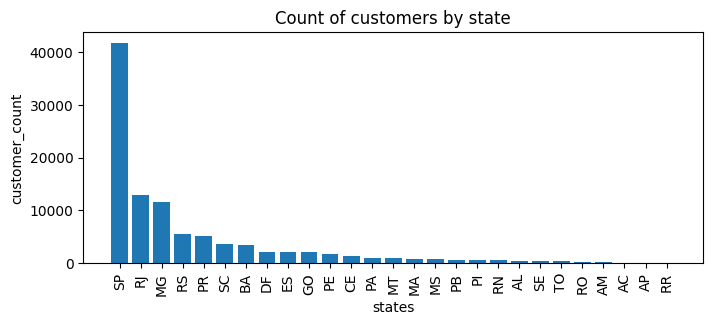

In [81]:
query = """ select customer_state, count(customer_id) from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State","customer_count"])
df = df.sort_values(by = "customer_count", ascending=False)

plt.figure(figsize = (8,3))
plt.bar(df["State"], df["customer_count"])
plt.xticks(rotation = 90 )
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customers by state")
plt.show

# Calculate the number of orders per month in 2018

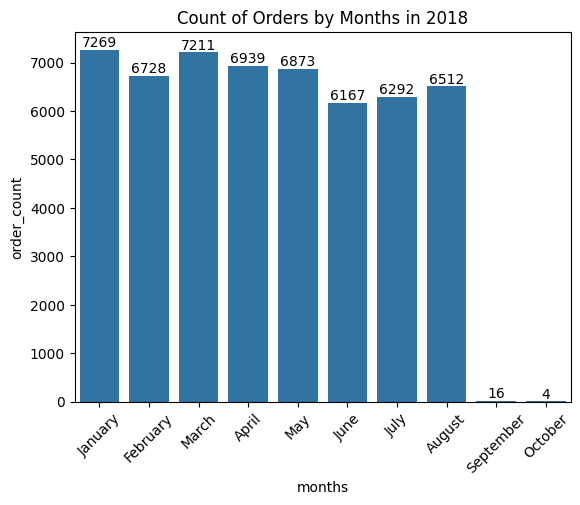

In [69]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) from orders 
where year(order_purchase_timestamp)=2018
group by months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months","order_count"])

o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o) 
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

# Find the average number of products per order, grouped by customer city

In [89]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city
order by average_order desc """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['customer_city','average products per order'])
df

,customer_city,average products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Identify the correlation between product price and the number of times a product has been purchased

In [127]:
query = """ select products.product_category, count(order_items.product_id), round(avg(order_items.price),2) price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['product_category','order_count','price'])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is     " , a[0][-1])

The correlation between product price and the number of times a product has been purchased is      -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

In [129]:
query = """ select *, dense_rank() over(order by revenue desc) as rnk from
(select order_items.seller_id, round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id = payments.order_id 
group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['seller_id','revenue', 'Rank'])
df 

,seller_id,revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


# Calculate the moving average of order values for each customer over their order history

In [3]:
query = """ select customer_id, order_purchase_timestamp, payments,
avg(payments) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payments
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['customer_id','order_purchase_timestamp', 'payments', 'moving_avg'])
df 

,customer_id,order_purchase_timestamp,payments,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year

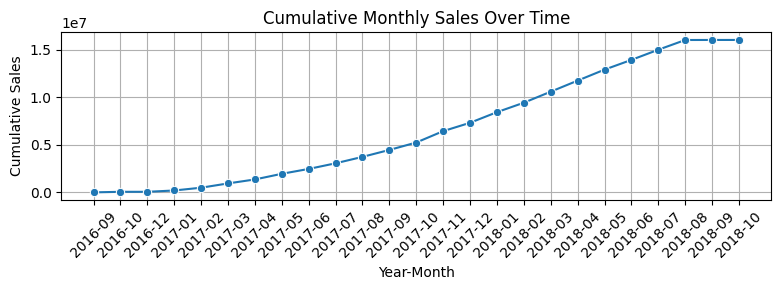

In [11]:
query = """ select years, months, payments, sum(payments)
 over(order by years, months) cummulative_sales from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments
from orders join payments
on payments.order_id = orders.order_id
group by years, months
order by years, months) as a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['years','months', 'payments', 'cummulative_sales'])
df['year_month'] = df['years'].astype(str) + '-' + df['months'].astype(str).str.zfill(2)

plt.figure(figsize = (8, 3))
sns.lineplot(data=df, x='year_month', y='cummulative_sales', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Monthly Sales Over Time')
plt.tight_layout()
plt.grid(True)
plt.show()

# Calculate the year-over-year growth rate of total sales

In [21]:
query = """ with a as 
(select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as payments
from orders join payments
on payments.order_id = orders.order_id
group by years
order by years)
select years, 
(payments-(lag(payments,1) over(order by years)))/(lag(payments,1) over(order by years))*100 previous_year 
from a """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["year","yoy % growth"])
df

,year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [23]:
query = """ with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)
select 100*(count(distinct a.customer_id))/(count(distinct b.customer_id)) 
from a left join b
on a.customer_id = b.customer_id; """

cur.execute(query)#

data = cur.fetchall()
data

[(None,)]

# As in this data, we don't have any repeating customers in intervals of 6 months, Hence getting no value 

# Identify the top 3 customers who spent the most money in each year

<function matplotlib.pyplot.show(close=None, block=None)>

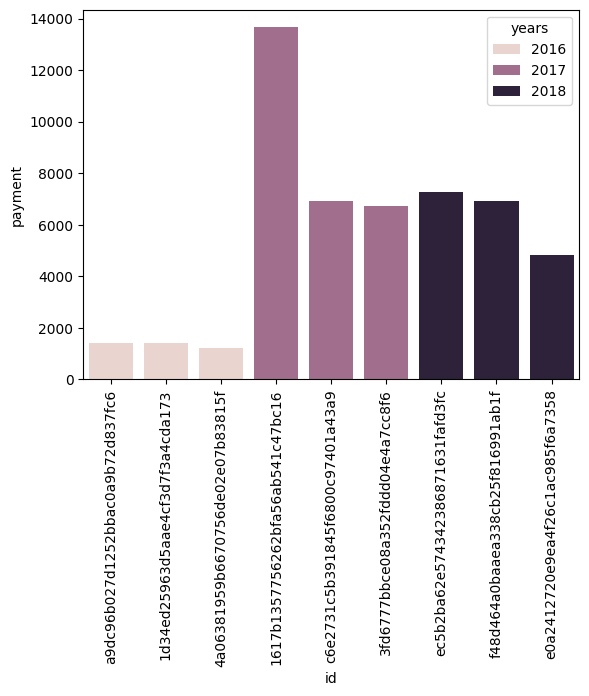

In [33]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3 """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['years','id', 'payment', 'rank'])
sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show